In [52]:
import os
import dotenv
import json
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from pydantic import BaseModel, Field
from google import genai
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [44]:
dotenv.load_dotenv()
API_KEY = os.getenv('GOOGLE_API_KEY')
MODEL_ID = "gemini-3-flash-preview"
client = genai.Client(api_key=API_KEY)

In [45]:
INPUT_CSV = "../data/test_data.csv"
BATCH_INPUT_FILE = "toxicity_batch_input.jsonl"
RAW_OUTPUT_FILE = "toxicity_raw_output.jsonl"
FINAL_CSV_FILE = "dataset_evaluated.csv"

In [46]:
# answer schema
class ToxicityAnalysis(BaseModel):
    toxicity: float = Field(..., description="General toxicity score (0-1).")
    severe_toxicity: float = Field(..., description="Severe toxicity score (0-1).")
    obscene: float = Field(..., description="Obscenity score (0-1).")
    threat: float = Field(..., description="Threat score (0-1).")
    insult: float = Field(..., description="Insult score (0-1).")
    identity_attack: float = Field(..., description="Identity attack score (0-1).")
    sexual_explicit: float = Field(..., description="Sexually explicit score (0-1).")
    deciding_fragments: List[str] = Field(..., description="Decisive text fragments.")
    justification: str = Field(..., description="Justification in text's original language.")

In [47]:
def prepare_batch_file(csv_path: str, jsonl_path: str):
    if not os.path.exists(csv_path):
        print(f"❌ Brak pliku wejściowego: {csv_path}")
        return None

    df = pd.read_csv(csv_path)
    print(f"🚀 Przygotowywanie wsadu dla {len(df)} rekordów...")

    # Pobieramy schemat JSON z Pydantic, aby wstawić go do requestu
    schema_dict = ToxicityAnalysis.model_json_schema()

    with open(jsonl_path, "w", encoding="utf-8") as f:
        for idx, row in df.iterrows():
            # Używamy indeksu jako ID
            req_id = str(idx)
            text = row['text']
            
            prompt_text = f"""Analyze toxicity for: "{text}". Return JSON based on schema. Justification in Polish."""

            # Budowanie request_body zgodnie z Twoim wzorcem
            request_body = {
                "custom_id": req_id,
                "method": "models.generateContent",
                "request": {
                    "model": f"models/{MODEL_ID}",
                    "contents": [
                        {"parts": [{"text": prompt_text}]}
                    ],
                    "generationConfig": {
                        "temperature": 0.0,
                        "response_mime_type": "application/json", # WYMUSZENIE JSON
                        "response_json_schema": schema_dict        # PRZEKAZANIE SCHEMATU
                    }
                }
            }
            f.write(json.dumps(request_body) + "\n")
            
    print(f"💾 Plik {jsonl_path} gotowy.")
    return len(df)

In [48]:
def run_batch_process():
    # A. Upload pliku
    print("⬆️ Wysyłanie pliku do Google...")
    batch_file = client.files.upload(
        file=BATCH_INPUT_FILE,
        config={'mime_type': 'application/json'} # Fix z Twojego kodu
    )

    # Czekanie na przetworzenie pliku (Active)
    while batch_file.state.name == "STATE_PROCESSING":
        print(".", end="", flush=True)
        time.sleep(2)
        batch_file = client.files.get(name=batch_file.name)
    
    print(f"\n✅ Plik aktywny: {batch_file.name}")

    # B. Uruchomienie zadania
    print(f"🚀 Uruchamianie zadania Batch (Model: {MODEL_ID})...")
    batch_job = client.batches.create(
        model=MODEL_ID,
        src=batch_file.name,
    )
    print(f"Job ID: {batch_job.name}")

    # C. Polling (Czekanie na wyniki)
    while True:
        job_status = client.batches.get(name=batch_job.name)
        print(f"Status: {job_status.state.name}") # Np. JOB_STATE_ACTIVE
        
        if job_status.state.name == "JOB_STATE_SUCCEEDED":
            print("🎉 Zadanie zakończone sukcesem!")
            return job_status
        elif job_status.state.name == "JOB_STATE_FAILED":
            raise Exception(f"❌ Zadanie nieudane: {job_status.error}")
        else:
            time.sleep(10)

In [51]:
# 1. Przygotuj plik JSONL
count = prepare_batch_file(INPUT_CSV, BATCH_INPUT_FILE)

# 2. Wyślij i czekaj
final_job_status = run_batch_process()

🚀 Przygotowywanie wsadu dla 400 rekordów...
💾 Plik toxicity_batch_input.jsonl gotowy.
⬆️ Wysyłanie pliku do Google...

✅ Plik aktywny: files/v226pc2sn9y8
🚀 Uruchamianie zadania Batch (Model: gemini-3-flash-preview)...
Job ID: batches/58k09ywu23sk1dqunv8gbcktsfldyma9fhka
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
Status: JOB_STATE_PENDING
S

In [53]:
def load_and_merge_data():
    print(f"📂 Loading Ground Truth: {INPUT_CSV}")
    df = pd.read_csv(INPUT_CSV)
    
    # Initialize prediction columns
    pred_cols = ['pred_toxicity', 'pred_severe_toxicity', 'pred_obscene', 
                 'pred_threat', 'pred_insult', 'pred_identity_attack', 'pred_sexual_explicit']
    for col in pred_cols:
        df[col] = np.nan # Use NumPy NaN for float compatibility

    print(f"📂 Loading Model Predictions: {RAW_OUTPUT_FILE}")
    try:
        with open(RAW_OUTPUT_FILE, 'r', encoding='utf-8') as f:
            lines = f.readlines()
    except FileNotFoundError:
        print("❌ JSONL file not found.")
        return None

    print(f"⚙️ Parsing {len(lines)} lines...")
    
    for line in lines:
        if not line.strip(): continue
        try:
            item = json.loads(line)
            idx = int(item['custom_id'])
            
            # Extract nested JSON logic
            response = item.get('response', {})
            if 'error' in response: continue
            
            candidates = response.get('candidates', [])
            if not candidates: continue
            
            parts = candidates[0].get('content', {}).get('parts', [])
            if not parts: continue
            
            # Clean and parse the inner JSON string
            raw_json = parts[0].get('text', '{}')
            clean_json = raw_json.replace('```json', '').replace('```', '').strip()
            data = json.loads(clean_json)
            
            # Assign to DataFrame
            df.at[idx, 'pred_toxicity'] = data.get('toxicity')
            df.at[idx, 'pred_severe_toxicity'] = data.get('severe_toxicity')
            df.at[idx, 'pred_obscene'] = data.get('obscene')
            df.at[idx, 'pred_threat'] = data.get('threat')
            df.at[idx, 'pred_insult'] = data.get('insult')
            df.at[idx, 'pred_identity_attack'] = data.get('identity_attack')
            df.at[idx, 'pred_sexual_explicit'] = data.get('sexual_explicit')
            
        except Exception:
            continue # Skip malformed lines
            
    return df

In [54]:
def preprocess_labels(df):
    print("\n🔧 Preprocessing & Feature Engineering...")
    
    # A. UZUPEŁNIANIE GROUND TRUTH (bin_toxicity)
    # Jeśli bin_toxicity jest puste, wyliczamy je z toxicity > 0.5
    if 'toxicity' in df.columns:
        mask_missing = df['bin_toxicity'].isna()
        # Wypełniamy tylko tam, gdzie mamy wynik ciągły 'toxicity'
        df.loc[mask_missing, 'bin_toxicity'] = (df.loc[mask_missing, 'toxicity'] > 0.5).astype(int)
    
    # B. TWORZENIE PREDYKCJI BINARNEJ (pred_bin_toxicity)
    # Model uważa za toksyczne wszystko powyżej 0.5
    df['pred_bin_toxicity'] = (df['pred_toxicity'] > 0.5).astype(int)
    
    # Usuwamy wiersze, gdzie nadal nie mamy Ground Truth (nawet po uzupełnieniu)
    # lub gdzie model nie zwrócił wyniku
    df_clean = df.dropna(subset=['bin_toxicity', 'pred_toxicity']).copy()
    
    # Upewniamy się, że bin_toxicity to int (dla macierzy pomyłek)
    df_clean['bin_toxicity'] = df_clean['bin_toxicity'].astype(int)
    
    print(f"✅ Data ready for analysis. Rows: {len(df_clean)} (Original: {len(df)})")

    df_clean.to_csv(FINAL_CSV_FILE, index=False)

    return df_clean

In [55]:
def evaluate_binary_global(df):
    print("\n" + "="*50)
    print("🌍 GLOBAL BINARY EVALUATION (All Data)")
    print("="*50)
    
    y_true = df['bin_toxicity']
    y_pred = df['pred_bin_toxicity']
    
    # 1. Metrics
    print(classification_report(y_true, y_pred, target_names=['Safe', 'Toxic']))
    acc = accuracy_score(y_true, y_pred)
    print(f"Global Accuracy: {acc:.2%}")
    
    # 2. Confusion Matrix Plot
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred: Safe', 'Pred: Toxic'],
                yticklabels=['Actual: Safe', 'Actual: Toxic'])
    plt.title('Global Confusion Matrix (bin_toxicity vs pred_bin_toxicity)')
    plt.ylabel('Ground Truth')
    plt.xlabel('Gemini Prediction')
    plt.show()

    # 3. Distribution of Model Scores by Binary Label
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='pred_toxicity', hue='bin_toxicity', 
                 bins=20, kde=True, palette={0: 'green', 1: 'red'}, element="step")
    plt.title('Distribution of Gemini Scores split by Human Binary Label')
    plt.xlabel('Gemini Predicted Score (0.0 - 1.0)')
    plt.axvline(0.5, color='black', linestyle='--', label='Threshold 0.5')
    plt.legend(title='Human Label')
    plt.show()

In [56]:
def evaluate_detailed_subset(df):
    # Wybieramy wiersze, które mają wypełnione szczegółowe kolumny Ground Truth
    detailed_cols = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack']
    
    # Sprawdzamy, które z tych kolumn istnieją w CSV
    available_cols = [c for c in detailed_cols if c in df.columns]
    
    if not available_cols:
        print("⚠️ No detailed columns found in CSV. Skipping detailed analysis.")
        return

    # Filtrujemy dane (musi mieć wartości w tych kolumnach)
    df_detail = df.dropna(subset=available_cols).copy()
    
    if len(df_detail) < 5:
        print("⚠️ Not enough data with detailed labels for correlation analysis.")
        return

    print("\n" + "="*50)
    print(f"🔬 DETAILED EVALUATION (Subset: {len(df_detail)} rows)")
    print("="*50)

    # 1. Correlation Matrix (Human vs AI for main categories)
    # Tworzymy pary (Human Col, AI Col)
    comparison_data = {}
    for col in available_cols:
        pred_col = f"pred_{col}"
        if pred_col in df_detail.columns:
            comparison_data[f"Human {col}"] = df_detail[col]
            comparison_data[f"AI {col}"] = df_detail[pred_col]
            
    corr_df = pd.DataFrame(comparison_data)
    corr_matrix = corr_df.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title('Correlation Heatmap: Human Labels vs AI Predictions')
    plt.show()

    # 2. Scatter Plot with Regression Line (Toxicity)
    if 'toxicity' in available_cols:
        plt.figure(figsize=(8, 8))
        sns.regplot(x='toxicity', y='pred_toxicity', data=df_detail, 
                    scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
        plt.plot([0, 1], [0, 1], 'g--', label='Perfect Match')
        plt.title('Regression Analysis: Human Toxicity vs AI Toxicity')
        plt.xlabel('Human Score')
        plt.ylabel('AI Prediction')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

📂 Loading Ground Truth: ../data/test_data.csv
📂 Loading Model Predictions: toxicity_raw_output.jsonl
⚙️ Parsing 400 lines...

🔧 Preprocessing & Feature Engineering...
✅ Data ready for analysis. Rows: 400 (Original: 400)

🌍 GLOBAL BINARY EVALUATION (All Data)
              precision    recall  f1-score   support

        Safe       0.94      0.89      0.92       278
       Toxic       0.78      0.87      0.82       122

    accuracy                           0.89       400
   macro avg       0.86      0.88      0.87       400
weighted avg       0.89      0.89      0.89       400

Global Accuracy: 88.50%


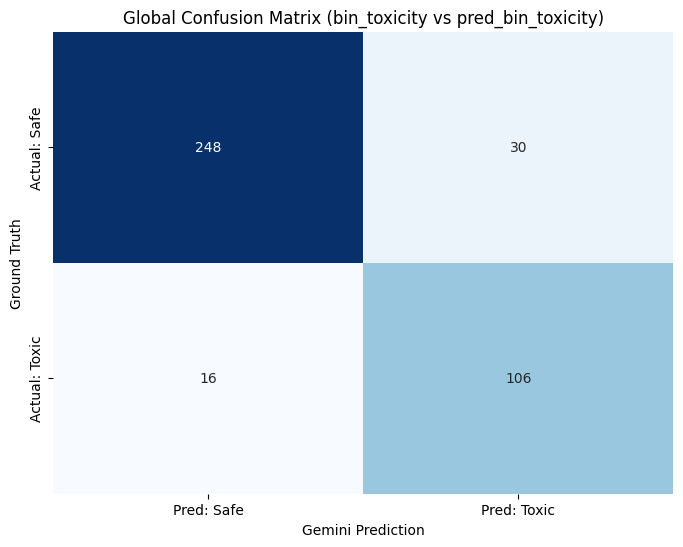

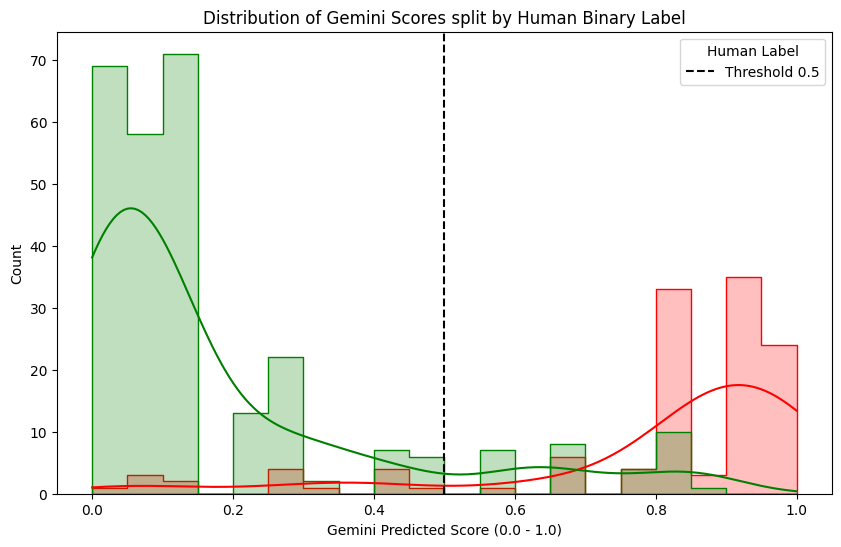


🔬 DETAILED EVALUATION (Subset: 200 rows)


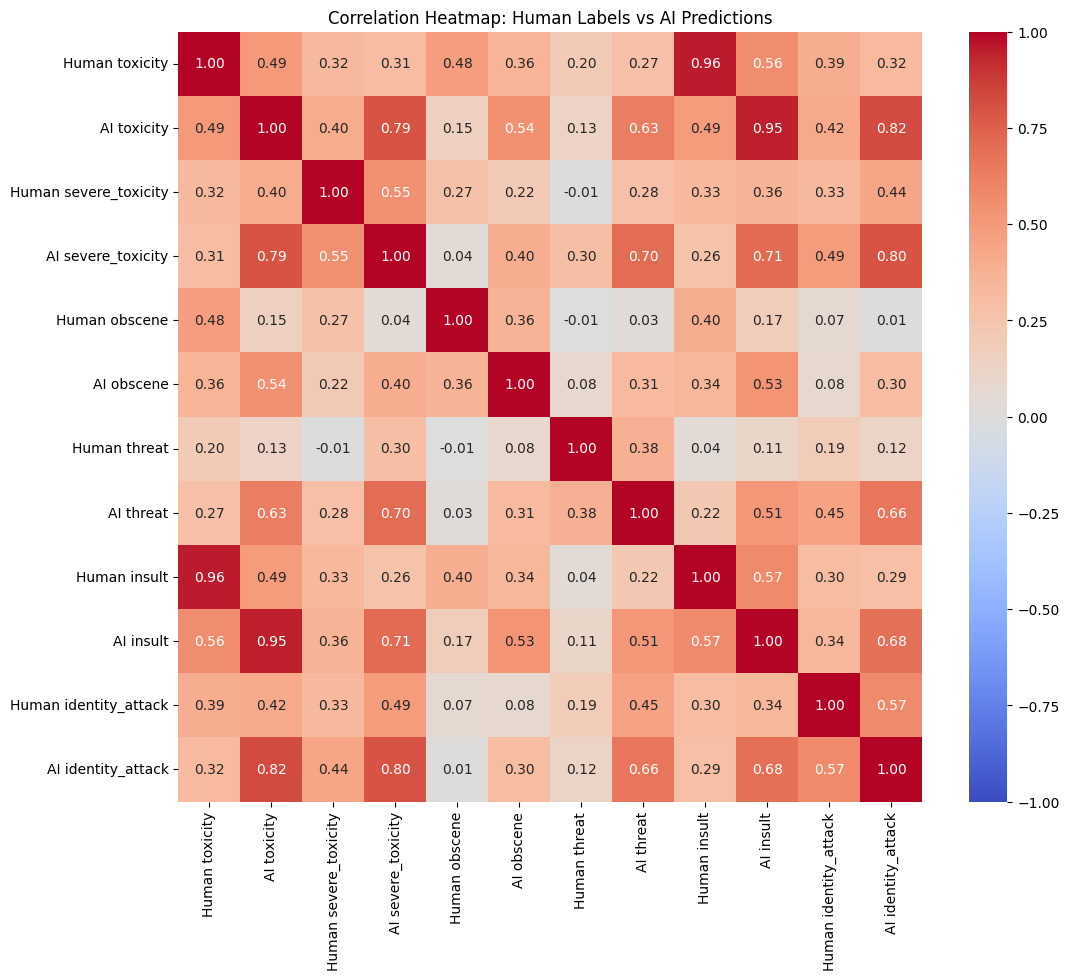

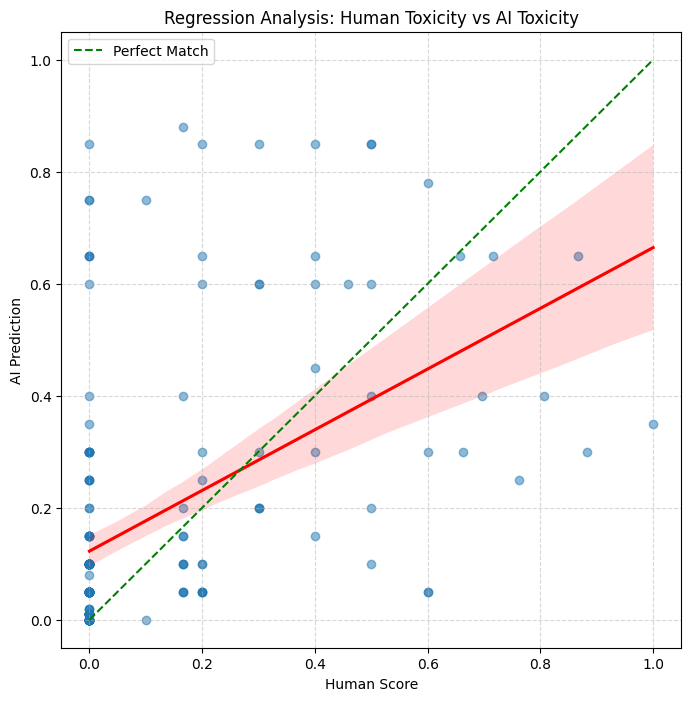

In [57]:
df_raw = load_and_merge_data()

df_processed = preprocess_labels(df_raw)

evaluate_binary_global(df_processed)

evaluate_detailed_subset(df_processed)